In [1]:
import sys
sys.path.insert(0, '../src')
import os
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import transformations as c
from topic_modelling.train.train_nmf import train_nmf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading data
current_path = os.getcwd()
root_path = os.path.dirname(current_path)
df = pd.read_csv(root_path + '/data/reviews.csv', encoding='unicode_escape')

In [3]:
df['stem_clean_text'] = df['Text'].apply(lambda x: c.get_cleantext(x, stemming=True))
num_topics = 20
n_top_words = 10
nmf_topic_words, nmf_pred, nmf_model = train_nmf(df, num_topics=num_topics, n_top_words=n_top_words)
df['nmf_pred'] = nmf_pred

In [4]:
df['Time'] = pd.to_datetime(df['Time'])

## Sentiment analysis

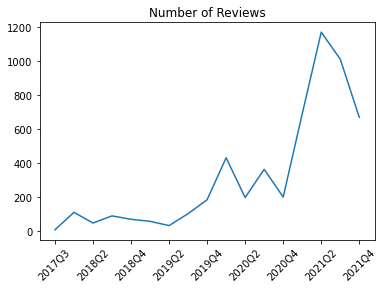

In [5]:
df['Time'].dt.to_period('Q').astype('str').value_counts().sort_index().plot()
plt.title('Number of Reviews')
plt.xticks(rotation = 45)
plt.show()

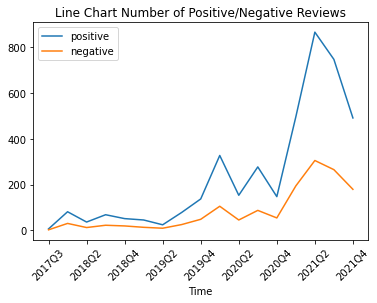

In [6]:
df[df['Sentiment']=='positive'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="line", label='positive')
df[df['Sentiment']=='negative'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="line", label='negative')
plt.legend(loc="upper left")
plt.title('Line Chart Number of Positive/Negative Reviews')
plt.xticks(rotation = 45)
plt.show()

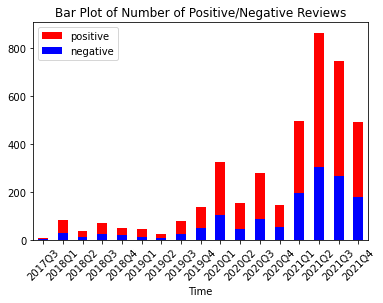

In [7]:
df[df['Sentiment']=='positive'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="bar", label='positive',color='r')
df[df['Sentiment']=='negative'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="bar", label='negative',color='b')
plt.legend(loc="upper left")
plt.title('Bar Plot of Number of Positive/Negative Reviews')
plt.xticks(rotation = 45)
plt.show()

In [8]:
df_count = df.groupby([df["Time"].dt.to_period('Q').astype('str'),df['Sentiment']], as_index=False).size()
df_count['perc']=df_count['size'] / df_count.groupby('Time')['size'].transform('sum')

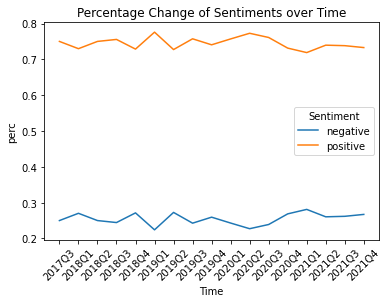

In [9]:
sns.lineplot(data=df_count, x='Time', y='perc', hue='Sentiment').set(title='Percentage Change of Sentiments over Time')
plt.xticks(rotation=45)
plt.show()

### Word Cloud for Positive/Negative Sentiments

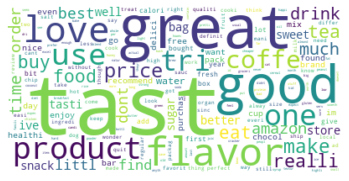

In [10]:
text = ','.join(list(df[df['Sentiment']=='positive']['stem_clean_text'].values))
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

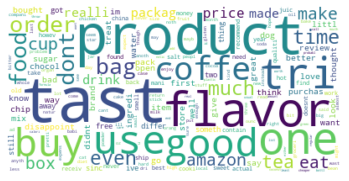

In [11]:
text = ','.join(list(df[df['Sentiment']=='negative']['stem_clean_text'].values))
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Topic Analysis

In [12]:
topics={0: 'Taste', 1: 'Coffee', 2: 'Tea', 3:'Amazon', 4: 'Taste/Price', 5: 'Healthy Snacks', 6: 'Dog Food', 7 : 'Healthy Carbohydrates',
         8: 'Cold Beverages', 9: 'Hot Beverages', 10: 'Flavour', 11: 'Chips',12: 'Delivery Feedback', 13: 'Taste', 14: 'Saltiness',
         15: 'Recommendation',16: 'Trying', 17: 'Alternatives', 18: 'Cat/ Baby Food', 19: 'Cooking Ingredients'}

In [13]:
df['topic']=df['nmf_pred'].map(topics)

### Topics Distribution

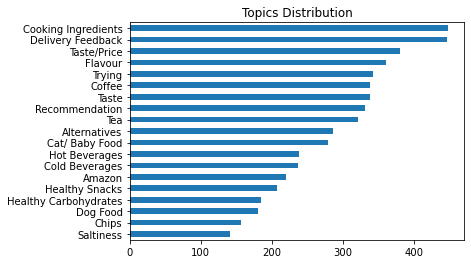

In [14]:
df['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics Distribution')
plt.show()

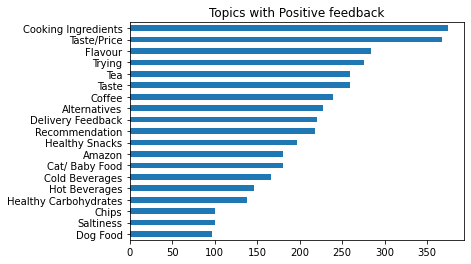

In [15]:
df[df['Sentiment']=='positive']['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics with Positive feedback')
plt.show()

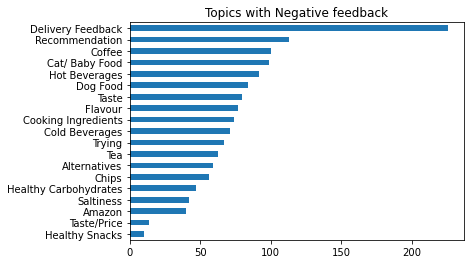

In [16]:
df[df['Sentiment']=='negative']['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics with Negative feedback')
plt.show()

### Popular Topics over Time

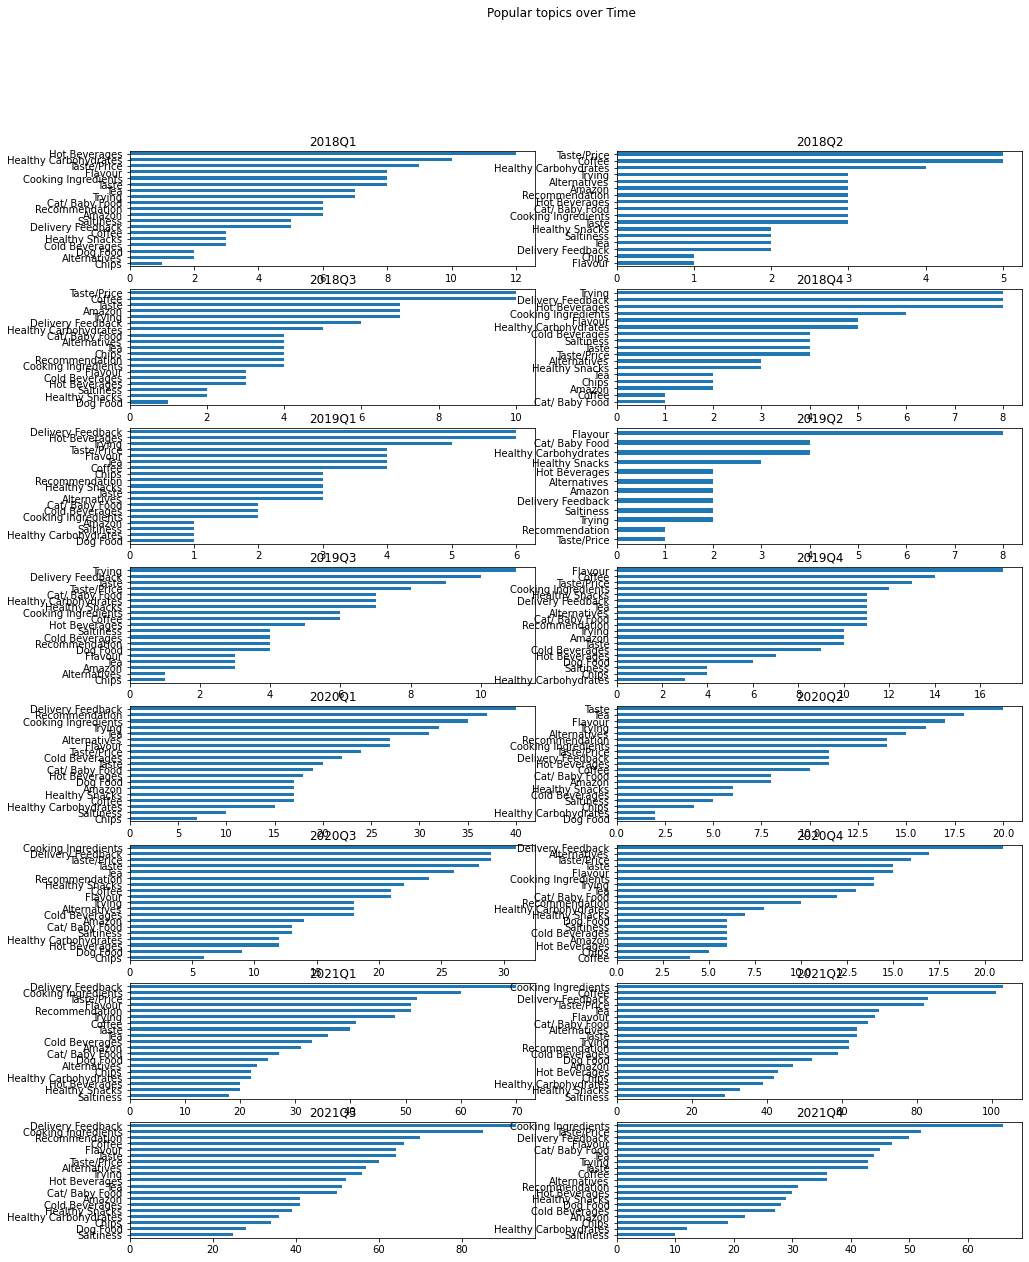

In [17]:
Period = np.unique(df["Time"].dt.to_period('Q').astype('str')).tolist()[1:]
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(16,20))
for i in range(16):
        plt.subplot(8, 2, i+1).set_title(Period[i])
        df[df["Time"].dt.to_period('Q').astype('str')==Period[i]]['topic'].value_counts().sort_values().plot(kind='barh')
fig.suptitle('Popular topics over Time')
plt.show()

### Word Cloud for Different Topics

In [18]:
def display_wordclouds(df, pred_col, num_topics):
    fig = plt.figure(figsize=(20,10))
    j = int(np.ceil(num_topics/4))
    for t in range(num_topics):
        # Join the different processed titles together.
        long_string = ','.join(list(df[df[pred_col]==t]['stem_clean_text'].values))
        # Create a WordCloud object
        wordcloud = WordCloud(width=700, height=250, 
                              background_color="white", 
                              max_words=500)
        if len(long_string)==0:
            long_string = 'None'
        # Generate a word cloud
        wordcloud.generate(long_string)
        i=t+1
        plt.subplot(j, 4, i).set_title(topics[t])
        plt.plot()
        plt.imshow(wordcloud)
        plt.axis("off")
    # plt.title(pred_col[:3].upper() + " Topics")
    plt.suptitle(pred_col[:3].upper() + " Topics", fontsize=30)
    plt.tight_layout()
    plt.show()

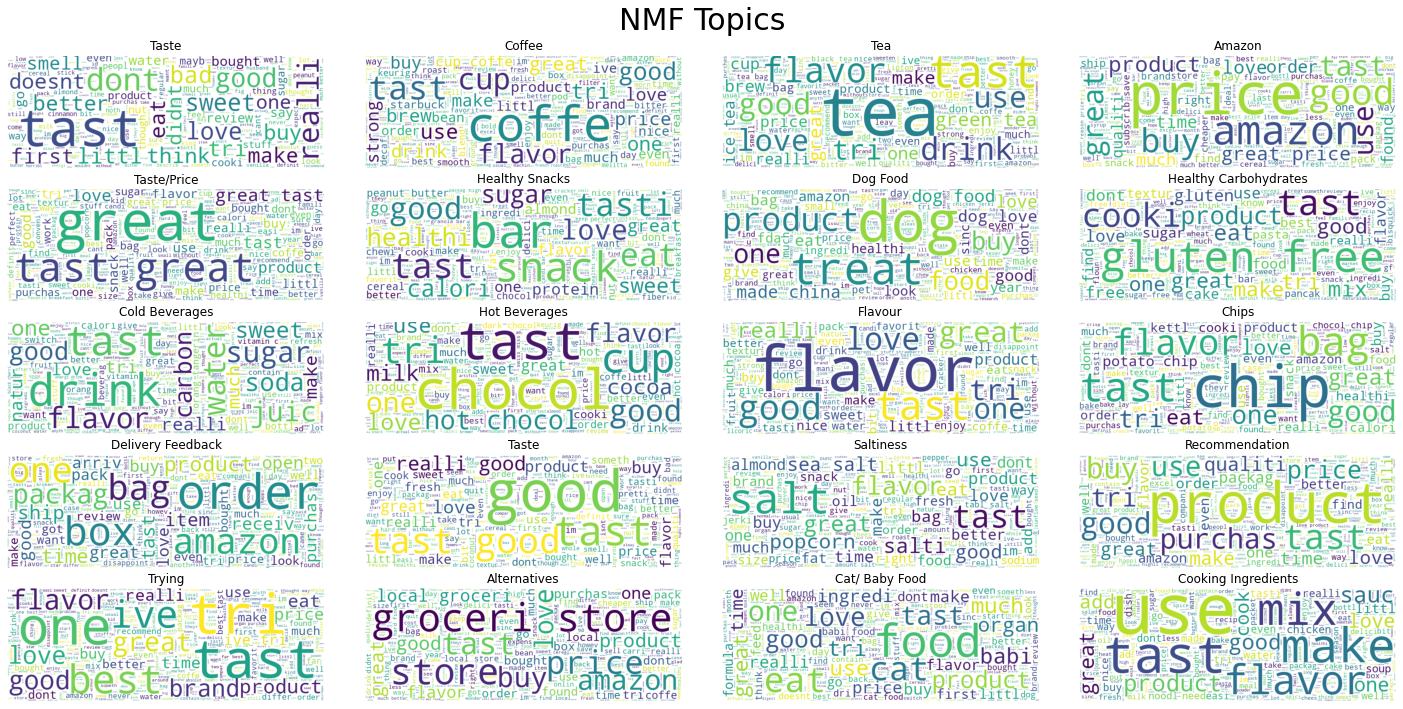

In [19]:
display_wordclouds(df, 'nmf_pred', num_topics=num_topics)